In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Patch
import importlib
import electricity_lib as ec_lib
import taipower_analyze_lib as analyze_lib

importlib.reload(ec_lib)
importlib.reload(analyze_lib)
pd.options.mode.chained_assignment = None  # default='warn'
# 設置微軟正黑體為全域字體
rcParams["font.family"] = "Microsoft JhengHei"

In [26]:
# 讀取充放電時間參數
meter_contract_volume_dict = analyze_lib.contract_df_to_dict(
    pd.read_excel(analyze_lib.METER_CONTRACT_FILE_PATH)
)
raw_data = pd.read_excel(analyze_lib.METER_DATA_FILE_PATH)
raw_data.drop(columns=analyze_lib.DEFAULT_DROP_COLS, inplace=True, errors="ignore")

METER_USAGE_COLS = analyze_lib.MeterUsageColumns()
ELEC_PRICE_COLS = analyze_lib.ElectricPriceColumns()
ELEC_PARAMS = analyze_lib.ElectricParameters(
    elec_type_dict=ec_lib.get_elec_type_dict(analyze_lib.CONTRACT_TYPE),
    release_hour_dict=ec_lib.get_release_hour_dict(
        analyze_lib.CONTRACT_TYPE, analyze_lib.RELEASE_TYPE
    ),
    charge_hour_dict=ec_lib.get_charege_hour_dict(analyze_lib.CONTRACT_TYPE),
)
ELEC_PRICE_PARAMS = analyze_lib.ElecetricPriceParameters(
    charge_price_dict=ec_lib.get_charge_price_dict(analyze_lib.CONTRACT_TYPE),
    contract_price_dict=ec_lib.get_contract_price_dict(analyze_lib.CONTRACT_TYPE),
)

# 將時間欄位轉換為日期時間格式
raw_data[METER_USAGE_COLS.time_col] = pd.to_datetime(
    raw_data[METER_USAGE_COLS.time_col]
)
raw_data[METER_USAGE_COLS.usage_col] = raw_data[analyze_lib.SUM_COLS].apply(
    lambda row: row.dropna().unique()[0] if row.nunique() == 1 else row.mode().iloc[0],
    axis=1,
)
raw_data[METER_USAGE_COLS.usage_col] = raw_data[METER_USAGE_COLS.usage_col] * 0.25
raw_data = raw_data.drop(columns=analyze_lib.SUM_COLS)

# 增加欄位，確定充放電狀態 & 充放電量
remain_battery_kw_list = []
battery_kwh_list = []
raw_data[
    [
        METER_USAGE_COLS.battery_kw_col,
        METER_USAGE_COLS.battery_kwh_col,
        METER_USAGE_COLS.usage_with_battery_col,
    ]
] = pd.DataFrame(
    raw_data.apply(
        lambda row: analyze_lib.process_battery_usage(
            row,
            METER_USAGE_COLS,
            ELEC_PARAMS,
            remain_battery_kw_list,
            battery_kwh_list,
        ),
        axis=1,
    ).tolist(),
    index=raw_data.index,
)

# 計算電價、調整後電價、需量價金
raw_data[
    [
        ELEC_PRICE_COLS.elec_charge_price_col,
        ELEC_PRICE_COLS.elec_charge_price_with_battery_col,
        ELEC_PRICE_COLS.demand_price_col,
    ]
] = pd.DataFrame(
    raw_data.apply(
        lambda row: analyze_lib.cal_elec_price(
            row,
            METER_USAGE_COLS,
            ELEC_PARAMS.elec_type_dict,
            ELEC_PRICE_PARAMS.charge_price_dict,
        ),
        axis=1,
    ).tolist(),
)

# calculate new contract volume
# calculate new basic contract price
contract_monthly_basic_price = analyze_lib.cal_monthly_basic_price(
    meter_contract_volume_dict, ELEC_PRICE_PARAMS.contract_price_dict, ec_lib.UsageType
)
new_contract_volume_dict = analyze_lib.cal_new_contract_volume(
    raw_data, METER_USAGE_COLS, ELEC_PARAMS.elec_type_dict
)
new_monthly_basic_price = analyze_lib.cal_monthly_basic_price(
    new_contract_volume_dict, ELEC_PRICE_PARAMS.contract_price_dict, ec_lib.UsageType
)

monthly_data = analyze_lib.group_data_in_freq(
    raw_data,
    "M",
    METER_USAGE_COLS,
    ELEC_PRICE_COLS,
)
# raw_data group by month
# diplay monthly price of charge, basic and demand price

d:\JUIC3\taipower-data-analyze\taipower_analyze_lib.py:93: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data.groupby(pd.Grouper(key=usage_cols.time_col, freq=freq))


            時間     用電總量     電池放電功率      電池容量  增加電池後用電量     原始流動電價  增加電池後流動電價  \
0   2024-09-01   219.25  12.956522  11073.20    144.75  1905.2825  1257.8775   
1   2024-09-02   312.25  15.869565  10986.45    221.00  2713.4525  1920.4900   
2   2024-09-03   303.25  13.739130  11049.45    224.25  2635.2425  1948.7325   
3   2024-09-04   284.00  14.695652  11026.45    199.50  2467.9600  1733.6550   
4   2024-09-05   303.25  15.521739  11006.70    214.00  2635.2425  1859.6600   
..         ...      ...        ...       ...       ...        ...        ...   
229 2025-04-18  1025.00  24.758621  27152.45    666.00  5155.7500  3349.9800   
230 2025-04-19     0.00        NaN      0.00      0.00     0.0000     0.0000   
231 2025-04-20     0.00        NaN      0.00      0.00     0.0000     0.0000   
232 2025-04-21  1213.00  27.327586  26989.95    816.75  6101.3900  4108.2525   
233 2025-04-22  1226.25  26.672414  27015.45    839.50  6168.0375  4222.6850   

       需量價金  
0     40.53  
1     61.88

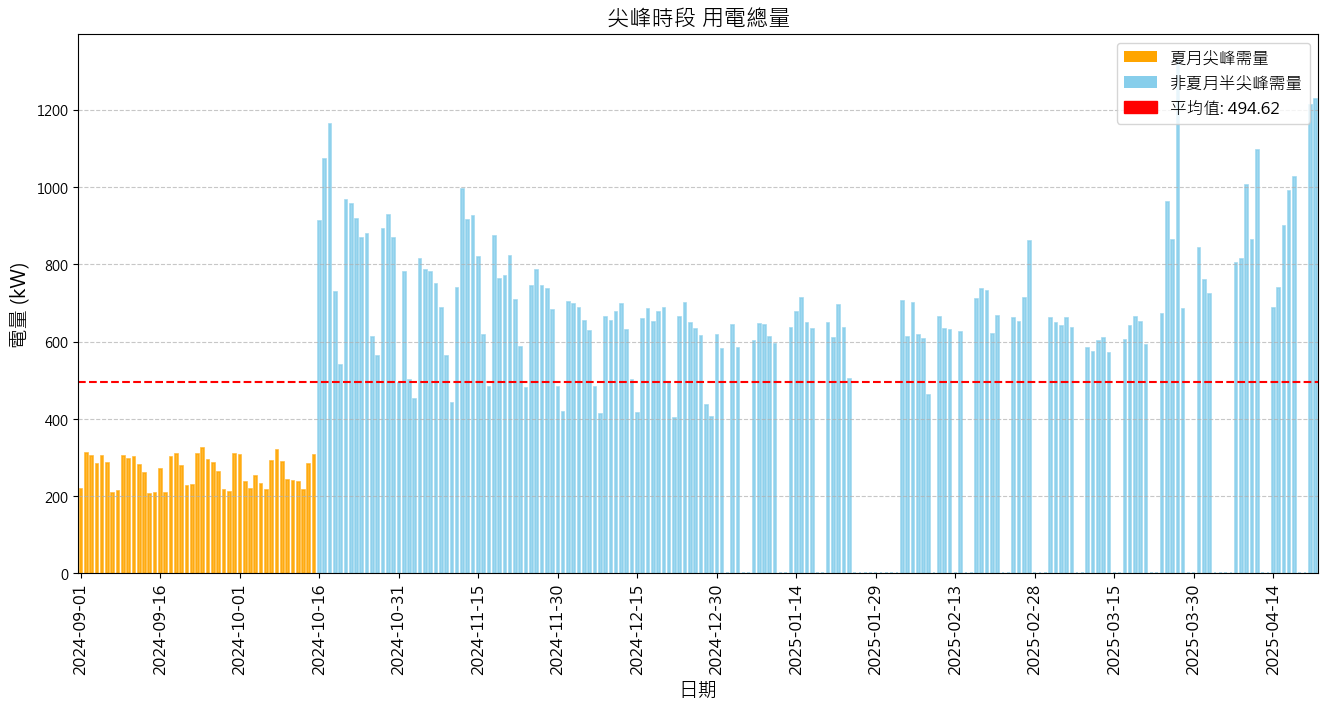

In [ ]:
expensive_summary = analyze_lib.filter_daily_expensive_hour_usage(
    raw_data, METER_USAGE_COLS, ELEC_PRICE_COLS, ELEC_PARAMS
)
usage_data = expensive_summary[METER_USAGE_COLS.usage_col]
average_power = usage_data.mean()
# 設置顏色：夏季（6月16日到10月15日）為橘色，其他為天藍色
colors = [
    (
        "orange"
        if (date.month > 5 or (date.month == 5 and date.day >= 16))
        and (date.month < 10 or (date.month == 10 and date.day <= 15))
        else "skyblue"
    )
    for date in expensive_summary[METER_USAGE_COLS.time_col]
]

# 繪製柱狀圖
usage_data.plot(
    kind="bar",
    figsize=(16, 7),
    color=colors,
    edgecolor=colors,
    linewidth=1.2,
    alpha=0.8,
)

# 設置平均線
plt.axhline(y=average_power, color="red", linestyle="--")

# 設置 X 軸的顯示間隔
x_labels = expensive_summary[METER_USAGE_COLS.time_col].dt.strftime("%Y-%m-%d").tolist()
plt.xticks(range(0, len(x_labels), 15), x_labels[::15], fontsize=12)

# 圖表設置
plt.title("尖峰時段 用電總量", fontsize=16)
plt.xlabel("日期", fontsize=14)
plt.ylabel("電量 (kW)", fontsize=14)

legend_elements = [
    Patch(facecolor="orange", label="夏月尖峰需量"),
    Patch(
        facecolor="skyblue",
        label=(
            "非夏月半尖峰需量"
            if analyze_lib.CONTRACT_TYPE
            == ec_lib.ContractType.HIGH_PRESSURE_THREE_PHASE
            else "非夏月尖峰需量"
        ),
    ),
    Patch(color="red", label=f"平均值: {average_power:.2f}"),
]
plt.legend(handles=legend_elements, fontsize=12, loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
plt.close("all")

In [ ]:
# 按日期統計用電總量
original_max_demand_power = raw_data[METER_USAGE_COLS.usage_col].max()
new_max_demand_power = raw_data[usage_with_battery_col].max()

# 設置顏色：夏季（6月16日到10月15日）為橘色，其他為天藍色

new_colors = [
    (
        "lawngreen"
        if (date.month > 5 or (date.month == 5 and date.day >= 16))
        and (date.month < 10 or (date.month == 10 and date.day <= 15))
        else "violet"
    )
    for date in lower_daily_summary[date_col]
]
fig, ax = plt.subplots(figsize=(16, 7))

summer_start_index, summer_end_index = 0, 0
for i in range(len(lower_daily_summary[date_col])):
    date = lower_daily_summary[date_col][i]
    if date.month == 5 and date.day == 16:
        summer_start_index = i
    elif date.month == 10 and date.day == 15:
        summer_end_index = i

ax.fill_between(
    range(len(lower_daily_summary[date_col])),
    lower_daily_summary[original_15_max_demand_col].values,
    label="Daily Summary",
    color="skyblue",
    linewidth=1.2,
    alpha=0.8,
)
ax.fill_between(
    range(summer_start_index, summer_end_index),
    lower_daily_summary[original_15_max_demand_col].values[
        summer_start_index:summer_end_index
    ],
    label="Daily Summary",
    color="orange",
    linewidth=1.2,
    alpha=0.8,
)

# 繪製第二個 DataFrame 的折線圖
ax.fill_between(
    range(len(lower_daily_summary[date_col])),
    lower_daily_summary[lower_15_max_demand_col].values,
    label="Lower Daily Summary",
    color="darkviolet",
    linewidth=1.2,
    alpha=0.8,
)

# 設置平均線
ax.axhline(y=original_max_demand_power, color="red", linestyle="--")
ax.axhline(y=new_max_demand_power, color="brown", linestyle="--")

# 設置 X 軸的顯示間隔
x_labels = lower_daily_summary[date_col]
tick_positions = range(0, len(x_labels), max(1, len(x_labels) // 15))  # 設置動態間隔
ax.set_xticks(tick_positions)
ax.set_xticklabels(x_labels[tick_positions], rotation=45, fontsize=12)
ax.set_xlim(left=0, right=len(x_labels))  # X 軸從 0 開始
ax.set_ylim(bottom=0)

# 圖表設置
plt.title("尖峰時段 15分鐘最高需量", fontsize=16)
plt.xlabel("日期", fontsize=14)
plt.ylabel("最高需量 (kW)", fontsize=14)

legend_elements = [
    Patch(facecolor="orange", label="(原)夏月尖峰需量"),
    Patch(facecolor="skyblue", label="(原)非夏月尖峰需量"),
    Patch(color="red", label=f"(原)尖峰最高需量: {original_max_demand_power:.2f}"),
    Patch(color="brown", label=f"新尖峰最高需量: {new_max_demand_power:.2f}"),
]
plt.legend(handles=legend_elements, fontsize=12, loc="upper right")
plt.show()